Training model...
Training Episode 1/100, Reward: 351.00
Training Episode 2/100, Reward: 1235.00
Training Episode 3/100, Reward: 1171.00
Training Episode 4/100, Reward: 1800.00
Training Episode 5/100, Reward: 2134.00
Training Episode 6/100, Reward: 1825.00
Training Episode 7/100, Reward: 2032.00
Training Episode 8/100, Reward: 1864.00
Training Episode 9/100, Reward: 2071.00
Training Episode 10/100, Reward: 2439.00
Training Episode 11/100, Reward: 2441.00
Training Episode 12/100, Reward: 1884.00
Training Episode 13/100, Reward: 2040.00
Training Episode 14/100, Reward: 2227.00
Training Episode 15/100, Reward: 2135.00
Training Episode 16/100, Reward: 2150.00
Training Episode 17/100, Reward: 2230.00
Training Episode 18/100, Reward: 1897.00
Training Episode 19/100, Reward: 2363.00
Training Episode 20/100, Reward: 2113.00
Training Episode 21/100, Reward: 1993.00
Training Episode 22/100, Reward: 2070.00
Training Episode 23/100, Reward: 2409.00
Training Episode 24/100, Reward: 2091.00
Training

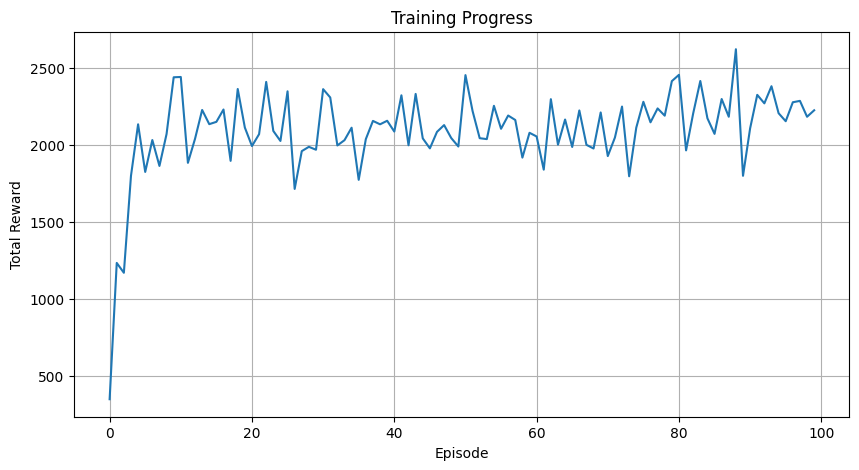

In [1]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("SUMO_HOME not found")

import traci

class RampMeteringEnv:
    def __init__(self, use_traffic_light=True):
        self.cfg_path = str(Path("D:/3CS/RL/rl for ramp metering/sumo/mynet.sumocfg"))
        self.sumoCmd = ["sumo", "-c", self.cfg_path, "--no-step-log", "--no-warnings"]
        self.use_traffic_light = use_traffic_light
        
        # Fixed lengths from SUMO network
        self.highway_length = 1000  # meters
        self.ramp_length = 100      # meters
        
        # Normalization constants
        self.MAX_DENSITY = 20.0
        self.MAX_QUEUE = 10.0
        self.MAX_SPEED = 13.89
        self.MAX_WAIT_TIME = 300.0
        
        # Q-learning parameters
        self.n_states = 4
        self.n_actions = 4
        self.q_table = {}
        
        # Network elements
        self.highway = "2to3"
        self.ramp = "intramp"
        self.tl_id = "node6"

    def start_simulation(self):
        try:
            traci.start(self.sumoCmd)
            return True
        except Exception as e:
            print(f"Error: {e}")
            return False

    def get_state(self):
        # Highway metrics (using fixed length)
        highway_density = traci.edge.getLastStepVehicleNumber(self.highway) / (self.highway_length/1000)
        highway_speed = traci.edge.getLastStepMeanSpeed(self.highway)
        
        # Ramp metrics
        ramp_queue = traci.edge.getLastStepHaltingNumber(self.ramp)
        ramp_speed = traci.edge.getLastStepMeanSpeed(self.ramp)
        
        # Normalize values
        norm_density = min(highway_density / self.MAX_DENSITY, 1.0)
        norm_queue = min(ramp_queue / self.MAX_QUEUE, 1.0)
        norm_highway_speed = min(highway_speed / self.MAX_SPEED, 1.0)
        norm_ramp_speed = min(ramp_speed / self.MAX_SPEED, 1.0)
        
        return tuple([norm_density, norm_queue, norm_highway_speed, norm_ramp_speed])

    def get_q_value(self, state, action=None):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.n_actions)
        if action is None:
            return self.q_table[state]
        return self.q_table[state][action]

    def take_action(self, action):
        if not self.use_traffic_light:
            traci.simulationStep()
            return self.get_state(), self.calculate_reward(), False
            
        green_times = [5, 10, 15, 20]
        try:
            traci.trafficlight.setPhaseDuration(self.tl_id, green_times[action])
            
            # Simulate for green time duration
            for _ in range(green_times[action]):
                if traci.simulation.getMinExpectedNumber() <= 0:
                    return self.get_state(), 0, True
                traci.simulationStep()
            
            return self.get_state(), self.calculate_reward(), False
        except:
            return self.get_state(), 0, True

    def calculate_reward(self):
        waiting_time = (traci.edge.getWaitingTime(self.highway) + 
                     traci.edge.getWaitingTime(self.ramp))
        
        vehicles = (traci.edge.getLastStepVehicleNumber(self.highway) + 
                   traci.edge.getLastStepVehicleNumber(self.ramp))
        
        return (-waiting_time + vehicles * 10)
def train_model(episodes=500):
    alpha = 0.01
    gamma = 0.99
    epsilon = 0.1
    env = RampMeteringEnv(use_traffic_light=True)
    results = []
    
    for episode in range(episodes):
        if not env.start_simulation():
            continue
            
        state = env.get_state()
        total_reward = 0
        
        while True:
            action = (np.random.randint(env.n_actions) if np.random.random() < epsilon 
                     else np.argmax(env.get_q_value(state)))
            
            next_state, reward, done = env.take_action(action)
            total_reward += reward
            
            best_next = np.max(env.get_q_value(next_state))
            env.q_table[state][action] += alpha * (reward + gamma * best_next - 
                                                 env.q_table[state][action])
            
            state = next_state
            if done:
                break

        traci.close()
        results.append(total_reward)
        print(f"Training Episode {episode+1}/{episodes}, Reward: {total_reward:.2f}")
    
    # Save trained model
    np.save('trained_q_table.npy', env.q_table)
    
    # Plot training progress
    plt.figure(figsize=(10, 5))
    plt.plot(results)
    plt.title('Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.savefig('training_progress.png')
    plt.show()
# Training phase
print("Training model...")
train_results = train_model(episodes=100)

Training model without traffic light...
Training Episode 1/100, Reward: -280.00
Training Episode 2/100, Reward: -280.00
Training Episode 3/100, Reward: -280.00
Training Episode 4/100, Reward: -280.00
Training Episode 5/100, Reward: -280.00
Training Episode 6/100, Reward: -280.00
Training Episode 7/100, Reward: -280.00
Training Episode 8/100, Reward: -280.00
Training Episode 9/100, Reward: -280.00
Training Episode 10/100, Reward: -280.00
Training Episode 11/100, Reward: -280.00
Training Episode 12/100, Reward: -280.00
Training Episode 13/100, Reward: -280.00
Training Episode 14/100, Reward: -280.00
Training Episode 15/100, Reward: -280.00
Training Episode 16/100, Reward: -280.00
Training Episode 17/100, Reward: -280.00
Training Episode 18/100, Reward: -280.00
Training Episode 19/100, Reward: -280.00
Training Episode 20/100, Reward: -280.00
Training Episode 21/100, Reward: -280.00
Training Episode 22/100, Reward: -280.00
Training Episode 23/100, Reward: -280.00
Training Episode 24/100, R

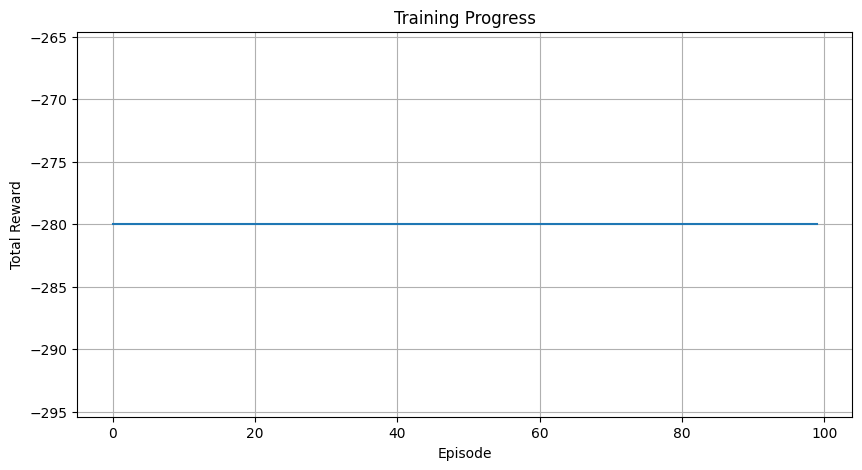

In [1]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("SUMO_HOME not found")

import traci

class RampMeteringEnv:
    def __init__(self):
        self.cfg_path = str(Path("D:/3CS/RL/rl for ramp metering/sumo/mynet.sumocfg"))
        self.sumoCmd = ["sumo", "-c", self.cfg_path, "--no-step-log", "--no-warnings"]

        # Fixed lengths from SUMO network
        self.highway_length = 1000  # meters
        self.ramp_length = 100      # meters

        # Normalization constants
        self.MAX_DENSITY = 20.0
        self.MAX_QUEUE = 10.0
        self.MAX_SPEED = 13.89
        self.MAX_WAIT_TIME = 300.0

        # Q-learning parameters
        self.n_states = 4
        self.n_actions = 4  # Different metering rates
        self.q_table = {}

        # Network elements
        self.highway = "2to3"
        self.ramp = "intramp"

    def start_simulation(self):
        try:
            traci.start(self.sumoCmd)
            return True
        except Exception as e:
            print(f"Error: {e}")
            return False

    def get_state(self):
        # Highway metrics (using fixed length)
        highway_density = traci.edge.getLastStepVehicleNumber(self.highway) / (self.highway_length/1000)
        highway_speed = traci.edge.getLastStepMeanSpeed(self.highway)

        # Ramp metrics
        ramp_queue = traci.edge.getLastStepHaltingNumber(self.ramp)
        ramp_speed = traci.edge.getLastStepMeanSpeed(self.ramp)

        # Normalize values
        norm_density = min(highway_density / self.MAX_DENSITY, 1.0)
        norm_queue = min(ramp_queue / self.MAX_QUEUE, 1.0)
        norm_highway_speed = min(highway_speed / self.MAX_SPEED, 1.0)
        norm_ramp_speed = min(ramp_speed / self.MAX_SPEED, 1.0)

        return tuple([norm_density, norm_queue, norm_highway_speed, norm_ramp_speed])

    def get_q_value(self, state, action=None):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.n_actions)
        if action is None:
            return self.q_table[state]
        return self.q_table[state][action]

    def take_action(self, action):
        # Define ramp inflow rates based on actions (e.g., vehicles per second)
        inflow_rates = [0.2, 0.5, 1.0, 2.0]  # vehicles/second
        inflow_rate = inflow_rates[action]

        try:
            # Control ramp inflow by adding vehicles at a controlled rate
            traci.edge.adaptTraveltime(self.ramp, 1 / inflow_rate)  # Adjust travel time to simulate metering

            # Simulate for a fixed number of steps (e.g., 10 seconds)
            for _ in range(10):
                if traci.simulation.getMinExpectedNumber() <= 0:
                    return self.get_state(), 0, True
                traci.simulationStep()

            return self.get_state(), self.calculate_reward(), False
        except Exception as e:
            print(f"Error during action execution: {e}")
            return self.get_state(), 0, True

    def calculate_reward(self):
        waiting_time = (traci.edge.getWaitingTime(self.highway) + 
                        traci.edge.getWaitingTime(self.ramp))

        vehicles = (traci.edge.getLastStepVehicleNumber(self.highway) + 
                    traci.edge.getLastStepVehicleNumber(self.ramp))

        return (-waiting_time + vehicles * 10)

def train_model(episodes=500):
    alpha = 0.01
    gamma = 0.99
    epsilon = 0.1
    env = RampMeteringEnv()
    results = []

    for episode in range(episodes):
        if not env.start_simulation():
            continue

        state = env.get_state()
        total_reward = 0

        while True:
            action = (np.random.randint(env.n_actions) if np.random.random() < epsilon 
                      else np.argmax(env.get_q_value(state)))

            next_state, reward, done = env.take_action(action)
            total_reward += reward

            best_next = np.max(env.get_q_value(next_state))
            env.q_table[state][action] += alpha * (reward + gamma * best_next - 
                                                   env.q_table[state][action])

            state = next_state
            if done:
                break

        traci.close()
        results.append(total_reward)
        print(f"Training Episode {episode+1}/{episodes}, Reward: {total_reward:.2f}")

    # Save trained model
    np.save('trained_q_table_no_traffic_light.npy', env.q_table)

    # Plot training progress
    plt.figure(figsize=(10, 5))
    plt.plot(results)
    plt.title('Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.savefig('training_progress_no_traffic_light.png')
    plt.show()

# Training phase
print("Training model without traffic light...")
train_results = train_model(episodes=100)
